In [706]:
# Import libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
timeframe = "hourly"
symbols = ["SPY"]
systems = ["Strat_TL"] # TL = Trading lab
starting_balance = 10000
risk_per_trade = 0.02 # Risking 2% per trade
sl_range = np.arange(2.0, 2.5, 0.5)
tp_range = np.arange(1, 8, 1)
bb_range = np.arange(30, 35, 5)

stop_type = "middle_bb" # Stop types are "middle_bb", "upper_bb" and "ratio"

# Strategy Inputs
bb_std = 2.0
rsi_length = 13
rsi_level = 30

In [708]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    return df

In [709]:
def calculate_inputs(df, bb_length):
    # Compute Bollinger Bands

    bbands = df.ta.bbands(bb_length, bb_std)
    df["BB_Upper"] = bbands[f"BBU_{bb_length}_{bb_std}"]
    df["BB_Middle"] = bbands[f"BBM_{bb_length}_{bb_std}"]
    df["BB_Lower"] = bbands[f"BBL_{bb_length}_{bb_std}"]

    # Compute RSI for oversold condition
    df["RSI"] = df.ta.rsi(length=rsi_length)

    # Compute ATR for stop loss
    df["ATR"] = df.ta.atr(length=14)

    return df


In [710]:
def generate_signals(df, s, sl, tp):

    # Entry conditions
    c1 = (df["Close"] < df["BB_Lower"]) # Price closes below lower bollinger band
    c2 = (df["RSI"] < rsi_level) # RSI is oversold, which is good for long entries

    # Entries depend on the strategy
    df[f"{s}_Signal"] = c1.shift(1) & c2.shift(1)
    
    # Generate exits
    df["SL"] = df["Open"] - (df["ATR"].shift(1) * sl)
    
    if stop_type == "middle_bb":
        df["TP"] = df["BB_Middle"].shift(1) # TP at middle bollinger band
    elif stop_type == "upper_bb":
        df["TP"] = df["BB_Upper"].shift(1) # TP at middle bollinger band
    elif stop_type == "ratio":
        stop_size = df["ATR"].shift(1) * sl
        df["TP"] = df["Open"] + stop_size * tp # TP as a ratio of the stop loss

    return df

In [711]:
def generate_trades(df, s, starting_balance, risk_per_trade):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    
    #iterate through rows to work out entries and exits
    for i, row in df.iterrows():
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated at the close and enter at the same time
            if row[f"{s}_Signal"] == True:
                entry_date = i
                entry_price = row.Open
                sl = row.SL
                tp = row.TP

                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                position_size = risk_amount / abs(entry_price - sl)  # Position size in units

                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            low = row.Low
            high = row.High
            # Track the open change while the trade is open to monitor balance during the trade.
            open_change[i] = low / entry_price

            # Calculate unrealized PnL
            floating_pnl = (high - entry_price) * position_size
            equity = balance + floating_pnl  # Update equity dynamically

            # Calculate unrealized PnL
            #check if stop is hit
            if low <= sl:
                #first check for a gap down
                if row.Open <= sl:
                    exit_price = row.Open
                else:
                    exit_price = sl
                trade_open = False

            # Now do the same check for take profit
            elif high >= tp:
                #first check for a gap up
                if row.Open >= tp:
                    exit_price = row.Open
                else:
                    exit_price = tp
                trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = i
                trade_open = False
                pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                balance += pnl  # Update balance with PnL

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    #trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values
    change_ser = pd.Series(open_change, name=f"{s}_Change")

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries, change_ser], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    #fill all the NaN return values with 1 as there was no loss on those days
    df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).fillna(method='ffill')
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).fillna(method='ffill')

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True
    
    return df, trades

In [712]:
def backtest(price, sl, tp, bb):

    for s in systems:
        #calculate strategy inputs
        price = calculate_inputs(price, bb)
        #generate signals
        price = generate_signals(price, s, sl, tp)
        #generate trades
        price, trades = generate_trades(price, s, starting_balance=starting_balance, risk_per_trade=risk_per_trade)
    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [713]:
results = []
prog = 0
max_prog = len(symbols) * len(sl_range) * len(tp_range) * len(bb_range)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for sl in sl_range:
        for tp in tp_range:
            for bb in bb_range:
                result, trades = backtest(price, sl, tp, bb)
                results.append(result)
                prog += 1
                clear_output(wait=True)
                print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 0.49073171615600586 s


In [714]:
#calculate metrics
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "hourly":
        N = 252 * 6.5 # number of trading hours per year (assuming 9:30 - 16:00 for NYSE)
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    #save data
    metrics["Start Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual Return"] = round(sys_cagr, 2)
    metrics["Time in Market"] = round(tim, 2)
    #metrics["Return_By_Exposure"] = rbe
    metrics["Max Drawdown"] = round(sys_dd, 2)
    #metrics["Return_Over_Drawdown"] = round(rod, 2)
    #metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    #metrics["Sharpe"] = round(sharpe, 2)
    #metrics["Sortino"] = round(sortino, 2)
    #metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    #metrics["Gap"] = round(gaps)
    #metrics["No_Gap"] = round(non_gaps)
    #metrics["Wins"] = round(wins, 2)
    #metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    #metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    #metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    #metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    #metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg RR"] = avg_rr
    
    return metrics

In [715]:
sys_metrics = {}

num_sl = len(sl_range)
num_tp = len(tp_range)

for count, res in enumerate(results):
    sl_idx = (count // num_tp) % num_sl  # Find stop loss index
    tp_idx = count % num_tp  # Find take profit index

    sl = sl_range[sl_idx]  # Get actual stop loss value
    tp = tp_range[tp_idx]  # Get actual take profit value

    for s in systems:
        key = f"{s}_sl{sl}_tp{tp}"
        sys_metrics.update({key: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

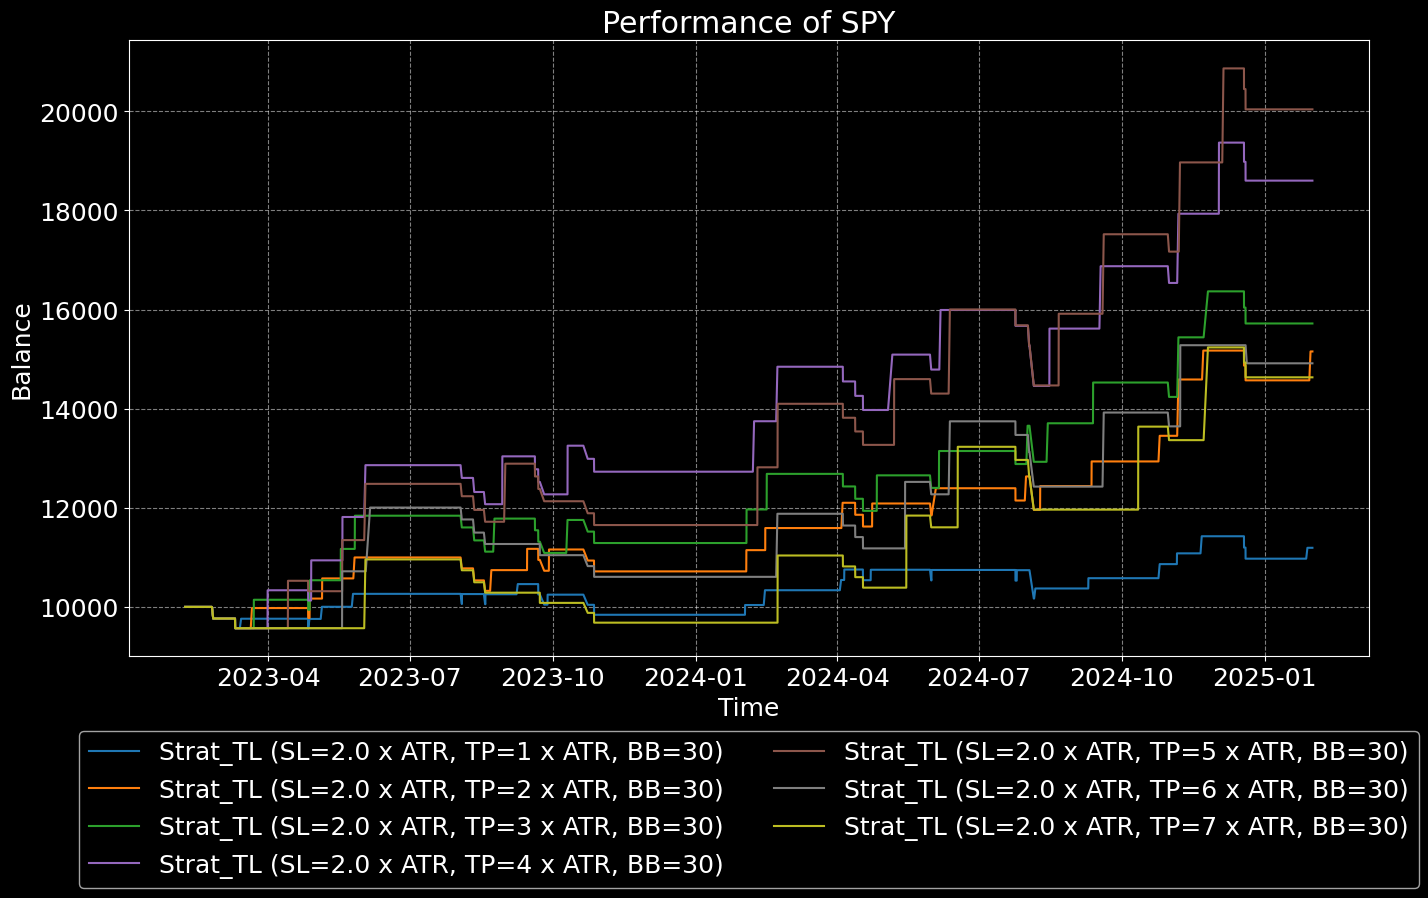

In [716]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

# Use a colormap for distinct colors
cmap = plt.get_cmap("tab10")  # You can try 'tab20', 'viridis', 'plasma', etc.

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    total_lines = len(sl_range) * len(tp_range) * len(bb_range) * len(systems)
    colors = [cmap(i / total_lines) for i in range(total_lines)]  # Generate distinct colors

    color_idx = 0  # Track color index

    for sl in sl_range:
        for tp in tp_range:
            for s in systems:
                for bb in bb_range:
                    result_idx = (
                        count * len(sl_range) * len(tp_range) * len(bb_range) +  # Symbol offset
                        list(sl_range).index(sl) * len(tp_range) * len(bb_range) +  # SL offset
                        list(tp_range).index(tp) * len(bb_range) +  # TP offset
                        list(bb_range).index(bb)  # BB offset
                    )

                    if result_idx >= len(results):  
                        continue  # Prevent out-of-bounds error
                
                    label = f"{s} (SL={sl} x ATR, TP={tp} x ATR, BB={bb})"
                    plt.plot(results[result_idx][f"{s}_Bal"], color=colors[color_idx], label=label)  # Use generated colors
                    legend_entries.append(label)

                    color_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [717]:
sys_metrics_df

,Strat_TL_sl2.0_tp1,Strat_TL_sl2.0_tp2,Strat_TL_sl2.0_tp3,Strat_TL_sl2.0_tp4,Strat_TL_sl2.0_tp5,Strat_TL_sl2.0_tp6,Strat_TL_sl2.0_tp7
Start Balance,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
Final Balance,11192.92,15154.85,15719.64,18602.17,20040.51,14915.81,14633.07
Annual Return,5.84,23.30,25.59,36.71,41.94,22.32,21.14
Time in Market,2.07,3.25,4.23,5.44,6.53,7.57,7.85
Max Drawdown,-5.92,-6.13,-6.34,-9.58,-9.61,-11.65,-11.65
Trades,36.00,36.00,35.00,35.00,33.00,24.00,24.00
Winrate,60.00,54.29,44.12,41.18,37.50,30.43,26.09
Avg RR,0.98,1.94,2.82,3.67,4.62,5.26,6.28
